In [1]:
import pandas as pd
import plotly.graph_objects as go
import sktime
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_parquet('train.parquet')
data.head(10)

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
5,59504,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[0.08, 0.88, 1.46, 0.59, -0.97, -0.41, 0.78, -...",0.0
6,49554,"[2016-04-01, 2016-05-01, 2016-06-01, 2016-07-0...","[1.05, -0.28, 1.09, -0.69, 1.26, 1.79, 1.38, -...",0.0
7,58344,"[2016-12-01, 2017-01-01, 2017-02-01, 2017-03-0...","[-0.36, -0.45, -0.4, -0.4, -0.45, -0.45, -0.45...",0.0
8,87449,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.92, 4.11, 3.39, -1.17, -0.79, 2.15, -0.22, ...",1.0
9,43415,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-0.86, -0.05, -0.35, -0.67, -0.25, -0.8, -0.6...",1.0



## Анализ


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


Видим, что в датасете нет пустых значений

In [4]:
min_label = min(data.groupby(by='label').size())
data.groupby(by='label').size()

label
0.0    57820
1.0    22180
dtype: int64

Выборка сильно несбалансирована, и один из способов сбалансировать ее - удалить строки, принадлежащие большему классу

In [5]:
data = pd.concat([data[data.label == 0].sample(min_label), data[data.label == 1].sample(min_label)]).sample(frac=1).reset_index(drop=True)

In [6]:
data['ndates'] = data['dates'].map(lambda x: len(x))
data['nvalues'] = data['values'].map(lambda x: len(x))
data

,id,dates,values,label,ndates,nvalues
0,20362,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.38, -0.67, -0.52, 0.1, -0.12, -0.71, 1.2, ...",0.0,76,76
1,5637,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[2.83, 1.5, 1.01, 1.33, 2.36, 2.3, 2.83, 1.69,...",1.0,55,55
2,39931,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.6, 1.73, -0.96, -1.05, 1.52, -1.83, -1.35, ...",0.0,80,80
3,82658,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.36, -0.47, -1.28, -0.62, -1.95, 0.04, 0.6, ...",0.0,93,93
4,42577,"[2016-11-01, 2016-12-01, 2017-01-01, 2017-02-0...","[1.84, 2.68, 2.2, 2.3, 0.71, 0.81, 1.0, -0.42,...",1.0,48,48
...,...,...,...,...,...,...
44355,64292,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.37, -1.12, 1.18, 2.13, -0.35, 0.81, 0.29, ...",1.0,48,48
44356,86832,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[0.87, 0.37, 0.78, 0.57, 1.35, 0.98, 0.75, -0....",1.0,69,69
44357,37240,"[2016-12-01, 2017-01-01, 2017-02-01, 2017-03-0...","[-1.61, -0.11, -0.2, -1.23, -1.11, -1.26, -1.0...",0.0,79,79
44358,89994,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.99, 1.26, 0.53, -0.03, -0.23, -1.2, -0.67, ...",1.0,94,94


In [7]:
data[data['ndates'] == data['nvalues']].shape

(44360, 6)

Количество дат и значений совпадает во всех строках

In [8]:
data.describe()

,id,label,ndates,nvalues
count,44360.000000,44360.000000,44360.000000,44360.000000
mean,50106.687601,0.500000,64.224842,64.224842
std,28883.277198,0.500006,15.299820,15.299820
min,1.000000,0.000000,36.000000,36.000000
25%,25140.750000,0.000000,52.000000,52.000000
50%,49980.500000,0.500000,62.000000,62.000000
75%,75181.250000,1.000000,76.000000,76.000000
max,99999.000000,1.000000,97.000000,97.000000



## Преобразование данных


Преобразуем таблицу в таблицу с мультииндексом и раскроем столбцы значений

In [31]:
df = data.explode(['dates', 'values']).dropna()
df['dates'] = df['dates'].apply(lambda x: pd.Timestamp(x))
df.index = pd.MultiIndex.from_frame(df[['id', 'dates']])
df['values'] = df['values'].astype(float)
df = df.drop(labels=['id', 'dates', 'ndates', 'nvalues'], axis=1)
df

values  label
id    dates                      
20362 2016-01-01 -0.380000    0.0
      2016-02-01 -0.670000    0.0
      2016-03-01 -0.520000    0.0
      2016-04-01  0.100000    0.0
      2016-05-01 -0.120000    0.0
...                    ...    ...
24228 2022-03-01  0.622338    1.0
      2022-04-01  1.162338    1.0
      2022-05-01 -3.147662    1.0
      2022-06-01 -3.207662    1.0
      2022-07-01 -2.667662    1.0

[2845875 rows x 2 columns]

In [32]:
df.groupby(by=df.label).size()

label
0.0    1436813
1.0    1409062
dtype: int64

In [33]:
train_ix, test_ix = train_test_split(df.index.levels[0], train_size=0.6)
X_train = df.loc[train_ix][['values']]
y_train = df.loc[train_ix].groupby(level=[0], sort=False)['label'].median()

X_test = df.loc[test_ix][['values']]
y_test = df.loc[test_ix].groupby(level=[0], sort=False)['label'].median()


## Обучение


In [34]:
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.classification.kernel_based import RocketClassifier

clf = PaddingTransformer() * RocketClassifier(n_jobs=-1, n_features_per_kernel=4, max_dilations_per_kernel=8, num_kernels=1000, use_multivariate='no')
clf.fit(X_train, y_train)
clf.save('model')
print(f' test accuracy score {clf.score(X_test, y_test):.3f}')

 test accuracy score 0.802



### Результаты


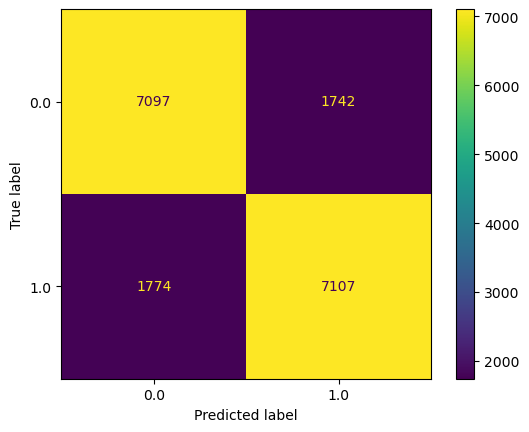

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

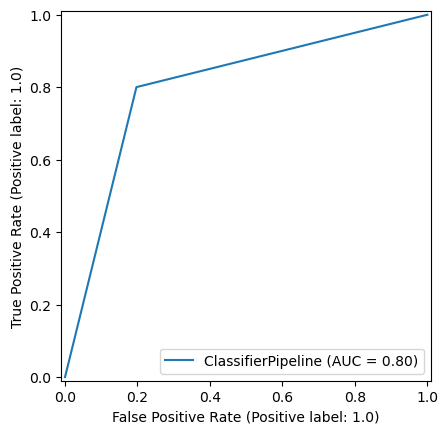

In [36]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(clf, X_test, y_test)